# Text Generator based on next character prediction

Made using a simple 2 hidden layered Neural Network, this text generator can predict next characters of the input text provided.

Here, the intension is not to generate meaningful sentences, we require a lot of compute for that. This app aims at showing how a vanilla neural network is also capable of capturing the format of English language, and generate words that are (very close to) valid words. Notice that the model uses capital letters (including capital I), punctuation marks and fullstops nearly correct. The text is generated paragraph wise, because the model learnt this from the text corpus.

This model was trained on a simple 600 KB text corpus titled: 'Gulliver's Travels'

Streamlit application: [Link](https://skynet-text-generator-ml.streamlit.app/)

This notebook contains a simple text generator that predicts the next character based on the previous k characters

In [1]:
# # !pip uninstall -y triton
# # %pip install triton
# # Uninstall existing PyTorch
# %pip uninstall -y torch torchvision torchaudio

# # Install CPU-only PyTorch
# %pip install torch 


In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [3]:
torch.__version__

'2.5.1+cpu'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cpu')

## Read the text corpus

The model is trained on the 600 KB text corpus titled: 'Gulliver's Travels'. This is available in the repository in a file named gt.txt .

In [6]:
with open('Shakespeare.txt', 'r') as file:
    thefile = file.read()

In [7]:
content = thefile[:-2000]
test = thefile[-2000:]

In [8]:
len(content), len(test)

(4571337, 2000)

In [9]:
print(type(content))

<class 'str'>


## Create a dictionary to store unique characters and their indices

In [10]:
stoi = {}
stoi['@'] = 0
i = 1
for char in sorted(content):
    if char not in stoi:
        stoi[char] = i
        i+=1

print(stoi)

{'@': 0, '\n': 1, ' ': 2, '!': 3, '$': 4, '&': 5, "'": 6, ',': 7, '-': 8, '.': 9, '3': 10, ':': 11, ';': 12, '?': 13, 'A': 14, 'B': 15, 'C': 16, 'D': 17, 'E': 18, 'F': 19, 'G': 20, 'H': 21, 'I': 22, 'J': 23, 'K': 24, 'L': 25, 'M': 26, 'N': 27, 'O': 28, 'P': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'W': 36, 'X': 37, 'Y': 38, 'Z': 39, '[': 40, ']': 41, 'a': 42, 'b': 43, 'c': 44, 'd': 45, 'e': 46, 'f': 47, 'g': 48, 'h': 49, 'i': 50, 'j': 51, 'k': 52, 'l': 53, 'm': 54, 'n': 55, 'o': 56, 'p': 57, 'q': 58, 'r': 59, 's': 60, 't': 61, 'u': 62, 'v': 63, 'w': 64, 'x': 65, 'y': 66, 'z': 67}


In [11]:
itos = {value: key for key, value in stoi.items()}

print(itos)

{0: '@', 1: '\n', 2: ' ', 3: '!', 4: '$', 5: '&', 6: "'", 7: ',', 8: '-', 9: '.', 10: '3', 11: ':', 12: ';', 13: '?', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'O', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: 'Z', 40: '[', 41: ']', 42: 'a', 43: 'b', 44: 'c', 45: 'd', 46: 'e', 47: 'f', 48: 'g', 49: 'h', 50: 'i', 51: 'j', 52: 'k', 53: 'l', 54: 'm', 55: 'n', 56: 'o', 57: 'p', 58: 'q', 59: 'r', 60: 's', 61: 't', 62: 'u', 63: 'v', 64: 'w', 65: 'x', 66: 'y', 67: 'z'}


## Set the block size

In [12]:
block_size = 15 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for i in range(len(content)-block_size-2):
  X.append([stoi[x] for x in content[i:i+block_size]])
  Y.append(stoi[content[i+block_size]])

# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

### Training data X and Y

In [13]:
X

tensor([[19, 50, 59,  ..., 55, 11,  1],
        [50, 59, 60,  ..., 11,  1, 15],
        [59, 60, 61,  ...,  1, 15, 46],
        ...,
        [42, 59, 61,  ..., 46, 55,  2],
        [59, 61, 49,  ..., 55,  2, 61],
        [61, 49,  2,  ...,  2, 61, 49]])

In [14]:
Y

tensor([15, 46, 47,  ..., 61, 49, 66])

In [15]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([4571320, 15]), torch.int64, torch.Size([4571320]), torch.int64)

## Set the Embedding size

In [22]:
# Embedding layer for the context

emb_dim = 15
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight.shape


torch.Size([68, 15])

## Visualizing the embedding

In [18]:
# # Function to visualize the embedding in 2d space if 2 dimensions are used

# def plot_emb(emb, itos, ax=None):
#     if ax is None:
#         fig, ax = plt.subplots()
#     for i in range(len(itos)):
#         x, y = emb.weight[i].detach().cpu().numpy()
#         ax.scatter(x, y, color='k')
#         ax.text(x + 0.05, y + 0.05, itos[i])
#     return ax

# plot_emb(emb, itos)

## Neural Network Model

In [19]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size1, hidden_size2):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    # x = torch.tanh(self.lin1(x)) # Activation function
    # x = torch.tanh(self.lin2(x))
    x = torch.sin(self.lin1(x)) # Activation function
    x = torch.sin(self.lin2(x))
    x = self.lin3(x)
    return x

## Generate text from the untrained model

In [23]:
# Enable high precision for float32 matrix multiplications
# torch.set_float32_matmul_precision('high')


In [24]:
model = NextChar(block_size, len(stoi), emb_dim, 500, 300).to(device)
model = torch.compile(model)

no_of_chars = 200
g = torch.Generator()
g.manual_seed(200)

def generate_text(model, inp, itos, stoi, block_size, max_len=no_of_chars):
    context = [0] * block_size
    # inp = inp.lower()
    if len(inp) <= block_size:
      for i in range(len(inp)):
        context[i] = stoi[inp[i]]
    else:
      j = 0
      for i in range(len(inp)-block_size,len(inp)):
        context[j] = stoi[inp[i]]
        j+=1

    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        if ix in itos:
          ch = itos[ix]
          name += ch
          context = context[1:] + [ix]
    return name

print(generate_text(model, "@", itos, stoi, block_size, no_of_chars))

W1029 17:05:32.902841 26444 site-packages\torch\_dynamo\convert_frame.py:1125] WON'T CONVERT forward C:\Users\JENIL\AppData\Local\Temp\ipykernel_26444\2291867377.py line 9 
W1029 17:05:32.902841 26444 site-packages\torch\_dynamo\convert_frame.py:1125] due to: 
W1029 17:05:32.902841 26444 site-packages\torch\_dynamo\convert_frame.py:1125] Traceback (most recent call last):
W1029 17:05:32.902841 26444 site-packages\torch\_dynamo\convert_frame.py:1125]   File "c:\Users\JENIL\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_inductor\cpp_builder.py", line 130, in check_compiler_exist_windows
W1029 17:05:32.902841 26444 site-packages\torch\_dynamo\convert_frame.py:1125]     subprocess.check_output([compiler, "/help"], stderr=subprocess.STDOUT)
W1029 17:05:32.902841 26444 site-packages\torch\_dynamo\convert_frame.py:1125]   File "C:\Users\JENIL\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 424, in check_output
W1029 17:05:32.902841 26444 site-packages\torch\_d

dDf,uuj[qkMMUPS;nICW?D!CsAiOv?RSbc$j!uofalIKQjvRhbthSwuQn:
DE[kJPJy- 3PQ.3EQQzGavY.h?Onppat-YZSPVNnEX$T ?sS@h'eR$LJfR d.:go',eDf;3kc.LquiIVli'PxYJ3g$;MOBPeLaR,[k;YfKCq-QGzw.
W@iPzao;!G@o-
tr$CcjxO@fAX


### Shapes of model's weights and biases

In [22]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([68, 15])
_orig_mod.lin1.weight torch.Size([500, 225])
_orig_mod.lin1.bias torch.Size([500])
_orig_mod.lin2.weight torch.Size([300, 500])
_orig_mod.lin2.bias torch.Size([300])
_orig_mod.lin3.weight torch.Size([68, 300])
_orig_mod.lin3.bias torch.Size([68])


## Train the model

In [23]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 10
elapsed_time = []
loss_arr = []
for epoch in range(200):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    loss_arr.append(loss.item())
    if epoch % print_every == 0:
        print(epoch, loss.item())


0 1.458317518234253
10 1.4360268115997314
20 1.427916169166565
30 1.4514493942260742
40 1.4673774242401123
50 1.4345308542251587
60 1.4137755632400513
70 1.4570322036743164
80 1.50613534450531
90 1.484678864479065
100 1.4461160898208618
110 1.530159831047058
120 1.4545533657073975
130 1.4874366521835327
140 1.5242043733596802
150 1.4156172275543213
160 1.4194144010543823
170 1.4282630681991577
180 1.4344180822372437
190 1.48983895778656


# Saving the model

In [24]:
torch.save(model, 'modelx.pth')


# Visualizing embeddings in higher dimensions using t-SNE

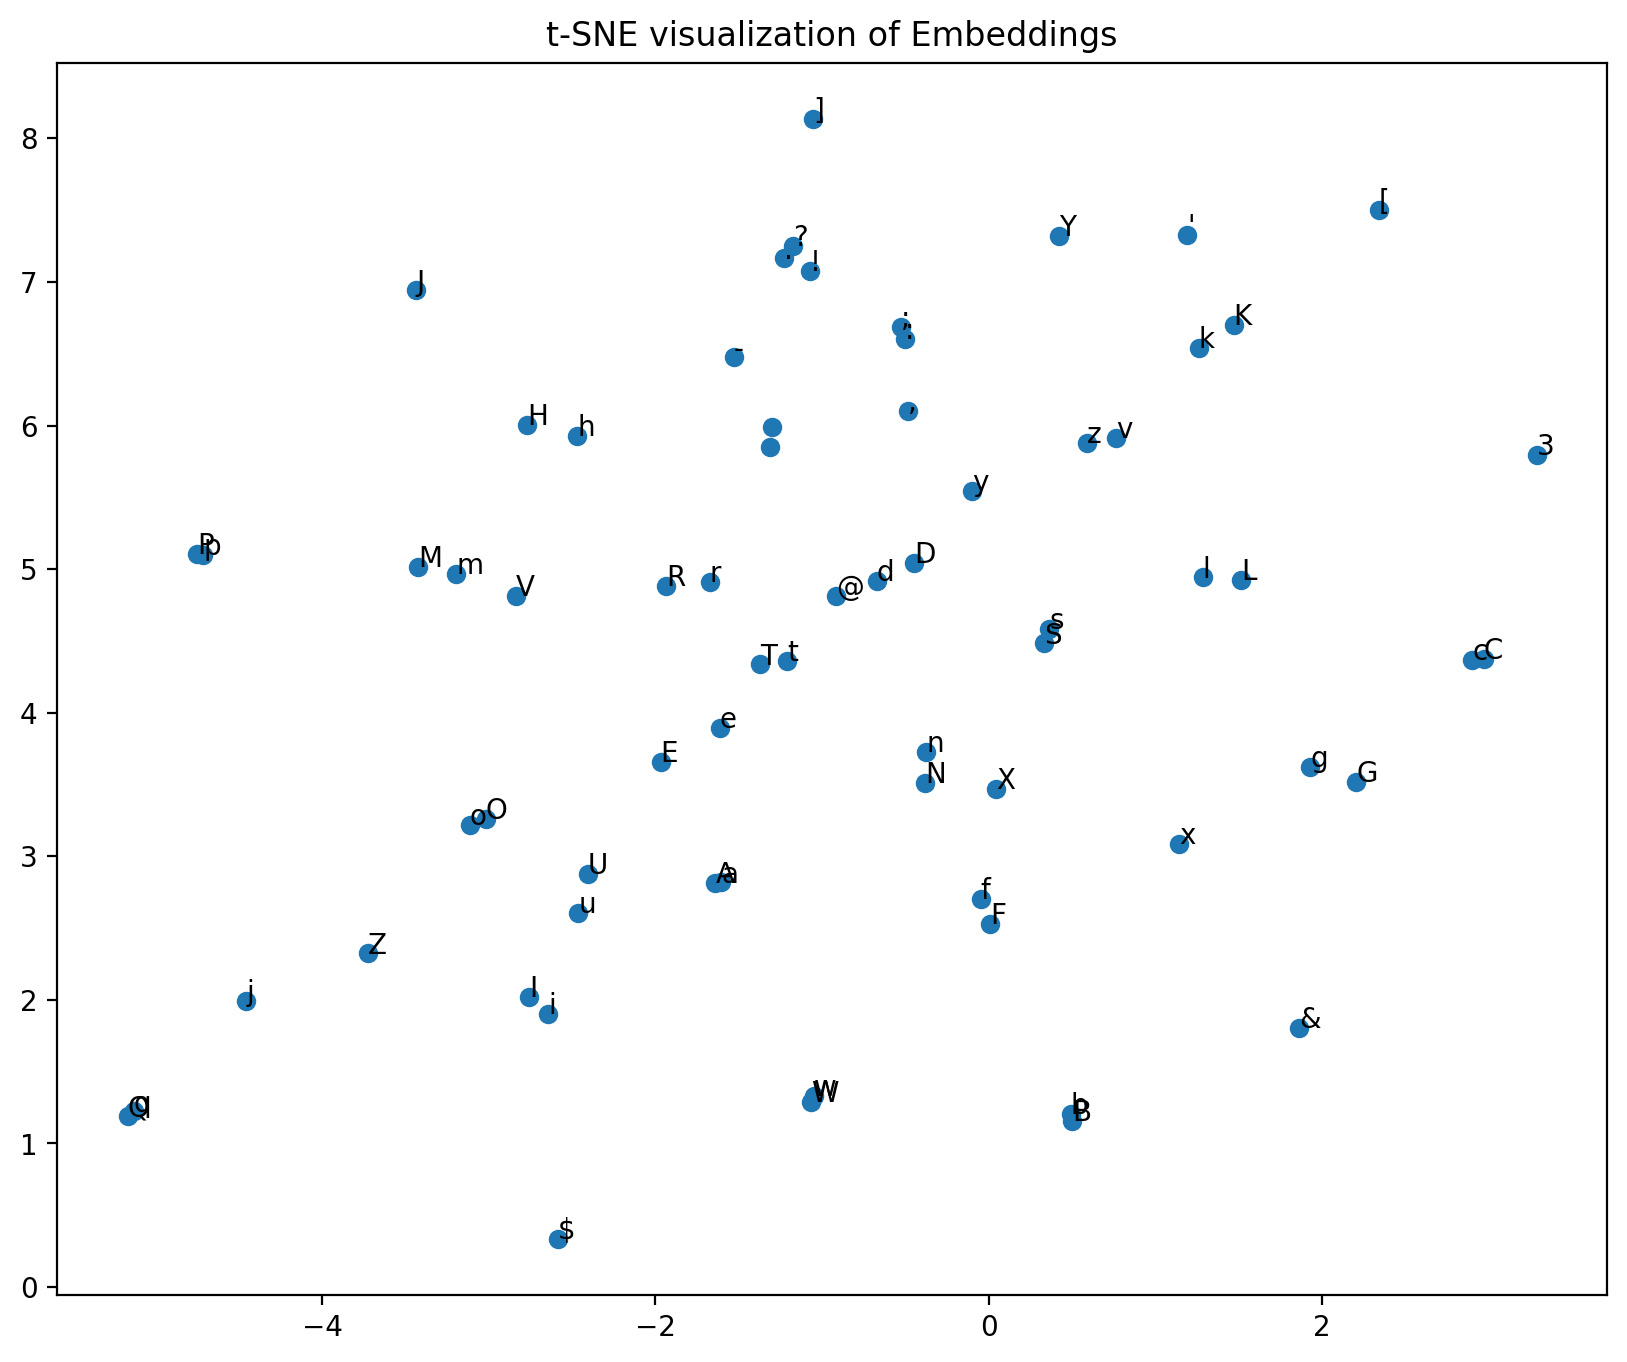

In [25]:
from sklearn.manifold import TSNE
if model.emb.weight.shape[1] > 2:
    embeddings = model.emb.weight.detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i in range(len(itos)):
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], itos[i])
    plt.title('t-SNE visualization of Embeddings')
    plt.show()
else:
    embeddings = model.emb.weight.detach().cpu().numpy()
    if embeddings.ndim == 1:
        plt.figure(figsize=(10, 8))
        for i, emb in enumerate(embeddings):
            plt.scatter(i, emb, color='k')
            plt.text(i + 0.05, emb + 0.05, itos[i])
        plt.title('1D Visualization of Embeddings')
        plt.show()
    else:
        plt.figure(figsize=(10, 8))
        for i in range(len(itos)):
            emb = embeddings[i][0]  # Extracting the single value from the array
            plt.scatter(i, emb, color='k')
            plt.text(i + 0.05, emb + 0.05, itos[i])
        plt.title('2D Visualization of Embeddings')
        plt.show()

## Generate text from the model

### Text generated without any seed text

In [26]:
print(generate_text(model, "", itos, stoi, block_size, 1000))

 and maken now of franch'de,
But whost that the blend,
If nevery thou aasatanss of fir ogvhout decoyst tonves burd colo!

Glown words.
Whus make have bu dies;
Unaiks,
Not windly anquite us Oloer and the slandifined to inds of I wat thou
Compable boved him: that I well suck he pi real for that be wit of warce,
The dunation for to strong.
But dro word blood.
Slear.
Ad bold repus'd Jood faol so dure but to you, unonine but daught
Put do eat-mere;
Art I wive you with pant for my bounds anmby
Tay Bere.

PEStURNIUS:
How blood and that the doman;
But, the finv you;H intasice I woumen sIffaths stavike of now
Empinny not the -dusmenned eyever this tome than we m off with beiginIus
Of the man lay day the ofk eson d moul make to were better'd and their bone bonattly and and my deace doy they of his peach, hand your hath like, in I lonconse?

HUBERt:
He I
adst the being make of not on Thy Torson by till amcherf't o-king and lord the noth thot-is nonest mome;
To my signs thou shalt, go great in a d

### Text generated with seed text provided

In [27]:
inp_str = "We are accounted poor citizens, the patricians"
print(inp_str+generate_text(model, inp_str, itos, stoi, block_size, 1000))

I love travelling around the sace, that will but offietly rew to stull it his tead this awouge of his
Make;
Igds well.

BEPtINC:
All whrn and of that nositarmn of their amed srowers steied this dack, emplney the floth thus as beath, the did by the ualt not well sudking gently whuse the hune as the confession essue.

CBAVY:
Bece, and the office of our toi musgetry hell to tharles the offediniatest,
I go old.

AONGn:
But on How dutime&

Is And inkince avheo boye,, do that.
Whergben you woo thee let tinip o'er to the trupont suchedce him brifliselleem.
Sit, I am ice it is leen to your of fae,
And to it dentle ebing of your o'er come fide of ofd as your law you havelest oftl'd fropresengts? Qoe sa fist on an exed,buch blood be seaT for agos!

VIATH:
Well hame at nor beough this relent anginor to grier-may.

First cowy-rour erfrid: goes adpeason ever thou real'd me what come thine pume usleens,
To veen and faith as thy tale offer, 'go on laugh or edach
Nife upon to a fant the reath? an thin

Text(0.5, 1.0, 'Loss vs Iterations. Emb size = 15. Block size = 15. 2 hidden layers')

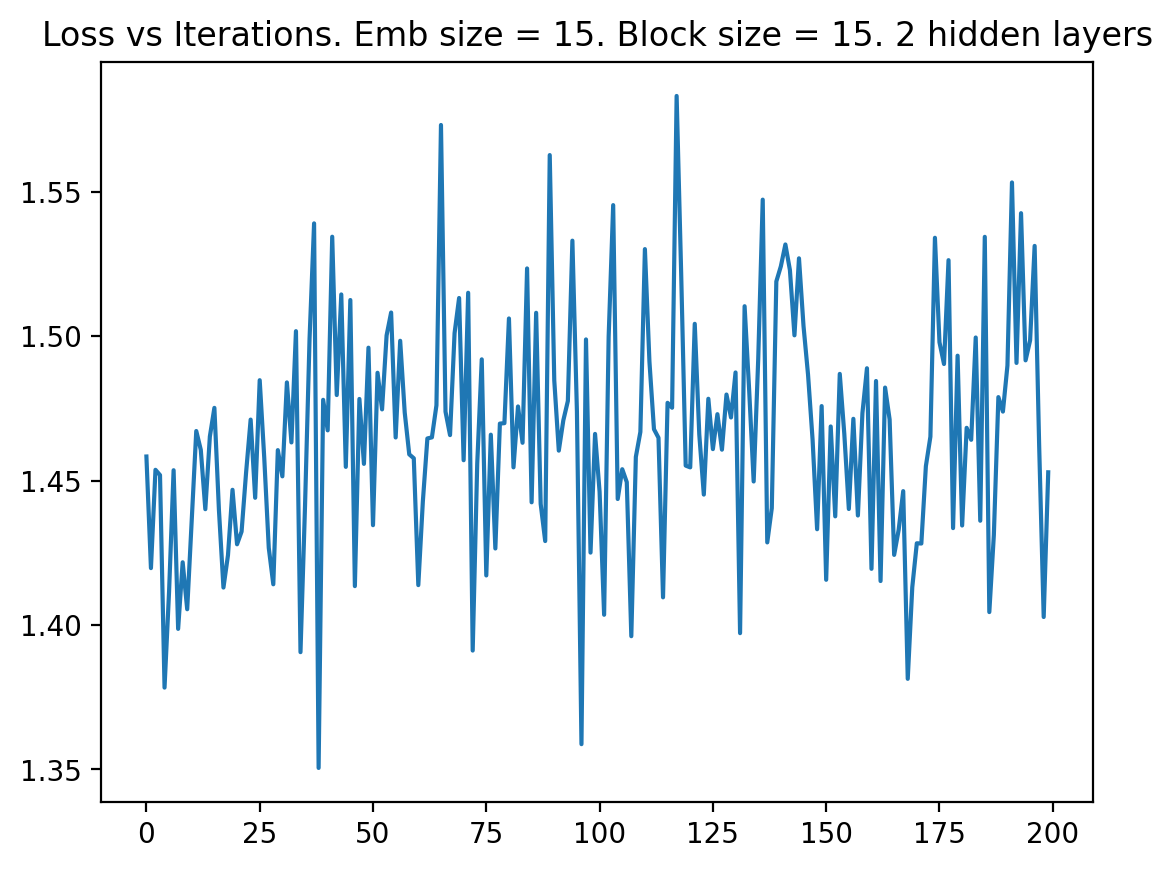

In [28]:
import numpy as np
plt.plot(np.arange(200),loss_arr)
plt.title("Loss vs Iterations. Emb size = 15. Block size = 15. 2 hidden layers")

In [29]:
torch.save(model.state_dict(),"gt_eng_model_upper_two_hid_layer_emb"+str(emb_dim)+"_block_size_"+str(block_size)+".pth")

Tuning knobs

1. Embedding size
2. Activation Function
3. Context length

### Streamlit Application
Explore changes in the text generated based on Embedding size, block size and seed text in the streamlit application:
[Link](https://skynet-text-generator-ml.streamlit.app/)